In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import io, transform
import pickle, bz2
%matplotlib inline

# Experiment with convolutions using them directly

See

- [Up-sampling with Transposed Convolution](https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0)
- [Types of convolution](https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d)
- [A guide to convolution arithmetic for deep learning](https://arxiv.org/abs/1603.07285)
- [Deconvolution and Checkerboard Artifacts](https://distill.pub/2016/deconv-checkerboard/)

### 2d convolution

load an image and one filter

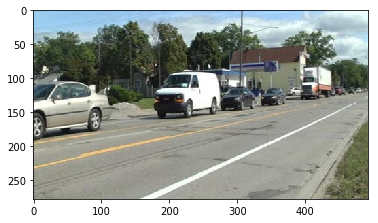

In [2]:
img = io.imread("Images/cars-driving.jpg")
plt.imshow(img)

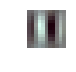

In [3]:
alex_c12 = pickle.load(bz2.BZ2File("data/alexnet_conv1_conv2.pklz", "r"))
filter_number = 90
akernel = alex_c12["conv1"][0][:,:,:,filter_number]
abias   = alex_c12["conv1"][1][filter_number]
plt.figure(figsize=(.7,.7))
plt.imshow((akernel-np.min(akernel))/(np.max(akernel)-np.min(akernel)))
plt.axis("off");

observe how we do one convolution, setting the initializers with the filter we just loaded

In [4]:
tf.reset_default_graph()
tX    = tf.placeholder(tf.float32, shape=[None] + list(img.shape), name="X")
layer = tf.layers.conv2d(tX, filters=1, kernel_size=[11,11], 
                         kernel_initializer=tf.initializers.constant(akernel),
                         bias_initializer=tf.initializers.constant(abias), 
                         activation="linear")
init  = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    output_img = sess.run(layer, feed_dict={tX: np.r_[[img]]})

In [5]:
print output_img.shape

(1, 268, 483, 1)


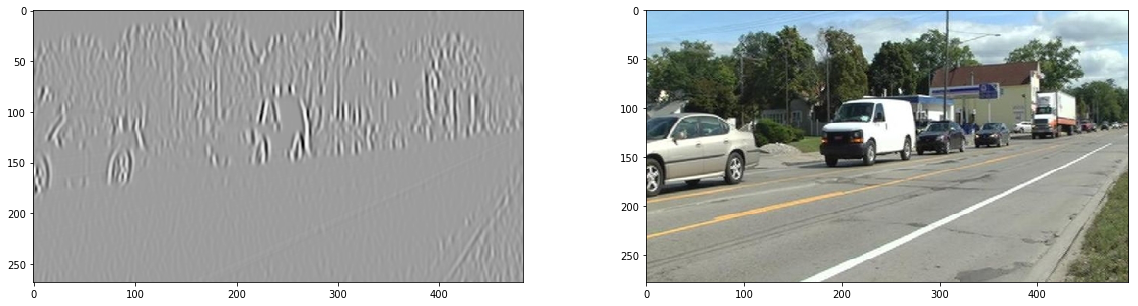

In [6]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(output_img[0,:,:,0], cmap=plt.cm.Greys_r)
plt.subplot(122)
plt.imshow(img)

observe how the layer internally creates TensorFlow variables

In [9]:
print "TF variables declared globally:"
print "\n".join([str(i) for i in layer.graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)])

TF variables declared globally:
<tf.Variable 'conv2d/kernel:0' shape=(11, 11, 3, 1) dtype=float32_ref>
<tf.Variable 'conv2d/bias:0' shape=(1,) dtype=float32_ref>


### 1d convolution

observe how {`tf.layers.conv1d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv1d) internally creates two variables

In [10]:
tf.reset_default_graph()
tX    = tf.placeholder(tf.float32, shape=[None, 6, 1], name="X")
layer = tf.layers.conv1d(tX, filters=2, kernel_size=3, 
                         bias_initializer=tf.initializers.random_uniform([2]), 
                         activation="tanh")

init  = tf.global_variables_initializer()

In [11]:
print "TF variables declared globally:"
print "\n".join([str(i) for i in layer.graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)])

TF variables declared globally:
<tf.Variable 'conv1d/kernel:0' shape=(3, 1, 2) dtype=float32_ref>
<tf.Variable 'conv1d/bias:0' shape=(2,) dtype=float32_ref>


In [12]:
tkernel, tbias = layer.graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

In [13]:
tkernel.shape, tbias.shape

(TensorShape([Dimension(3), Dimension(1), Dimension(2)]),
 TensorShape([Dimension(2)]))

observe how TF initializes the kernel and bias differently each time a session is run

In [14]:
for _ in range(2):
    with tf.Session() as sess:
        sess.run(init)
        kernel, bias = sess.run([tkernel, tbias])
        print "kernel shape", kernel.shape, "bias shape", bias.shape
        print "\n--", kernel
        print "\n--", bias
        print "\n"

kernel shape (3, 1, 2) bias shape (2,)

-- [[[-0.44046876  0.03115737]]

 [[ 0.2701398  -0.4646325 ]]

 [[ 0.15659034 -0.14430213]]]

-- [1.9252852 1.1824883]


kernel shape (3, 1, 2) bias shape (2,)

-- [[[-0.21043217 -0.2219795 ]]

 [[-0.63570654 -0.34516692]]

 [[ 0.05262458 -0.5292537 ]]]

-- [1.0517286 1.8107824]




### evaluating TensorFlow's convolution

first create a random input

In [15]:
size=7
X = np.random.randint(3, size=[size]+tX.shape.as_list()[1:])
X.shape

(7, 6, 1)

In [16]:
X.T

array([[[1, 1, 1, 0, 0, 2, 2],
        [2, 0, 0, 1, 2, 1, 1],
        [0, 2, 0, 1, 0, 1, 2],
        [2, 2, 1, 2, 1, 2, 0],
        [0, 0, 2, 1, 2, 0, 1],
        [1, 2, 2, 1, 1, 2, 2]]])

then feed it to the computational graph

In [17]:
with tf.Session() as sess:
    sess.run(init)
    output, kernel, bias = sess.run([layer, tkernel, tbias], feed_dict={tX: X})

In [18]:
print X.shape
print kernel.shape
print bias.shape
print output.shape

(7, 6, 1)
(3, 1, 2)
(2,)
(7, 4, 2)


In [19]:
print output

[[[0.88449556 0.73881966]
  [0.9369789  0.9697763 ]
  [0.87882787 0.7943872 ]
  [0.9372446  0.92459524]]

 [[0.93379605 0.9768605 ]
  [0.87783104 0.96545875]
  [0.8899139  0.6709883 ]
  [0.9369789  0.9697763 ]]

 [[0.93435216 0.85818416]
  [0.9307503  0.95541453]
  [0.90764856 0.9752557 ]
  [0.8835426  0.95496327]]

 [[0.9080322  0.93800807]
  [0.9120314  0.9676883 ]
  [0.8840201  0.8888875 ]
  [0.9165647  0.89579797]]

 [[0.87882787 0.7943872 ]
  [0.9372446  0.92459524]
  [0.90764856 0.9752557 ]
  [0.8840201  0.8888875 ]]

 [[0.9165647  0.89579797]
  [0.9120314  0.9676883 ]
  [0.88449556 0.73881966]
  [0.9369789  0.9697763 ]]

 [[0.91621524 0.95785606]
  [0.88449556 0.73881966]
  [0.9372446  0.92459524]
  [0.90764856 0.9752557 ]]]


### doing the convolution by hand

the loop is for each convolution step

In [20]:
c = np.r_[[np.tanh(X[:,i:i+kernel.shape[0],0].dot(kernel[:,0,:])+bias) \
            for i in range(X.shape[1]-kernel.shape[0]+1)]].swapaxes(0,1).reshape(output.shape)
c

array([[[0.88449564, 0.73881965],
        [0.93697891, 0.96977639],
        [0.87882794, 0.7943872 ],
        [0.93724458, 0.92459533]],

       [[0.93379604, 0.97686052],
        [0.87783112, 0.96545866],
        [0.88991378, 0.67098831],
        [0.93697891, 0.96977639]],

       [[0.93435218, 0.85818411],
        [0.93075038, 0.95541449],
        [0.90764866, 0.97525578],
        [0.88354256, 0.95496337]],

       [[0.90803211, 0.93800804],
        [0.91203142, 0.96768838],
        [0.88402002, 0.88888755],
        [0.91656476, 0.89579807]],

       [[0.87882794, 0.7943872 ],
        [0.93724458, 0.92459533],
        [0.90764866, 0.97525578],
        [0.88402002, 0.88888755]],

       [[0.91656476, 0.89579807],
        [0.91203142, 0.96768838],
        [0.88449564, 0.73881965],
        [0.93697891, 0.96977639]],

       [[0.91621532, 0.95785606],
        [0.88449564, 0.73881965],
        [0.93724458, 0.92459533],
        [0.90764866, 0.97525578]]])

In [21]:
np.allclose(output, c)

True

### using a convolution matrix

the filter is transformed into a matrix so that when doing matrix multiplication with the original input, the result contains the elements obtained through a sequential convolution.

In [22]:
def get_conv_matrix(input_shape, kernel):
     return np.r_[[[0]*i+list(kernel)+[0]*(input_shape[1]-kernel.shape[0]-i) \
                   for i in range(input_shape[1]-kernel.shape[0]+1)]]


convolution matrix for the first filter

In [23]:
cm = get_conv_matrix(X.shape,kernel[:,0,1])
print cm.shape
cm.T


(4, 6)


array([[-0.1353367 ,  0.        ,  0.        ,  0.        ],
       [-0.16926867, -0.1353367 ,  0.        ,  0.        ],
       [ 0.46872497, -0.16926867, -0.1353367 ,  0.        ],
       [ 0.        ,  0.46872497, -0.16926867, -0.1353367 ],
       [ 0.        ,  0.        ,  0.46872497, -0.16926867],
       [ 0.        ,  0.        ,  0.        ,  0.46872497]])

In [24]:
X.shape

(7, 6, 1)

In [25]:
np.tanh(X[:,:,0].dot(cm.T)+bias[0])

array([[0.83128465, 0.98135321, 0.86866563, 0.9530659 ],
       [0.98574348, 0.97867143, 0.78449115, 0.98135321],
       [0.91056436, 0.97241544, 0.98475003, 0.97213388],
       [0.96151563, 0.98005689, 0.93035242, 0.93477313],
       [0.86866563, 0.9530659 , 0.98475003, 0.93035242],
       [0.93477313, 0.98005689, 0.83128465, 0.98135321],
       [0.97393842, 0.83128465, 0.9530659 , 0.98475003]])

and for all the filters together

In [26]:
c = np.r_[[np.tanh(X[:,:,0].dot(get_conv_matrix(X.shape, kernel[:,0,i]).T)+bias[i]).T \
          for i in range(kernel.shape[-1])]].swapaxes(2,0).reshape(output.shape)
c

array([[[0.88449564, 0.73881965],
        [0.93697891, 0.96977639],
        [0.87882794, 0.7943872 ],
        [0.93724458, 0.92459533]],

       [[0.93379604, 0.97686052],
        [0.87783112, 0.96545866],
        [0.88991378, 0.67098831],
        [0.93697891, 0.96977639]],

       [[0.93435218, 0.85818411],
        [0.93075038, 0.95541449],
        [0.90764866, 0.97525578],
        [0.88354256, 0.95496337]],

       [[0.90803211, 0.93800804],
        [0.91203142, 0.96768838],
        [0.88402002, 0.88888755],
        [0.91656476, 0.89579807]],

       [[0.87882794, 0.7943872 ],
        [0.93724458, 0.92459533],
        [0.90764866, 0.97525578],
        [0.88402002, 0.88888755]],

       [[0.91656476, 0.89579807],
        [0.91203142, 0.96768838],
        [0.88449564, 0.73881965],
        [0.93697891, 0.96977639]],

       [[0.91621532, 0.95785606],
        [0.88449564, 0.73881965],
        [0.93724458, 0.92459533],
        [0.90764866, 0.97525578]]])

In [27]:
np.allclose(c, output)

True

### transposed convolution

In [28]:
cm = get_conv_matrix(X.shape,kernel[:,0,1])

direct convolution

In [29]:
np.tanh(X[:,:,0].dot(cm.T)+bias[0])

array([[0.83128465, 0.98135321, 0.86866563, 0.9530659 ],
       [0.98574348, 0.97867143, 0.78449115, 0.98135321],
       [0.91056436, 0.97241544, 0.98475003, 0.97213388],
       [0.96151563, 0.98005689, 0.93035242, 0.93477313],
       [0.86866563, 0.9530659 , 0.98475003, 0.93035242],
       [0.93477313, 0.98005689, 0.83128465, 0.98135321],
       [0.97393842, 0.83128465, 0.9530659 , 0.98475003]])

In [30]:
output.shape, X.shape, cm.shape

((7, 4, 2), (7, 6, 1), (4, 6))

transposed convolution. It recovers the **shape** of the original input (not the content)

In [31]:
tc = output[:,:,0].dot(cm).reshape(X.shape)
tc.T

array([[[-0.11970471, -0.12637687, -0.12645214, -0.12289008,
         -0.11893766, -0.12404484, -0.12399754],
        [-0.27652501, -0.27686517, -0.28412122, -0.27713272,
         -0.27560161, -0.27857701, -0.27479124],
        [ 0.13704632,  0.16866622,  0.15756916,  0.15159865,
          0.13044426,  0.15553371,  0.15289199],
        [ 0.16358378,  0.13401916,  0.16305371,  0.15381015,
          0.16603312,  0.15096688,  0.13310085],
        [ 0.25328242,  0.2585237 ,  0.27588146,  0.2592166 ,
          0.27580064,  0.25598398,  0.28567348],
        [ 0.43930994,  0.43918539,  0.41413847,  0.42961676,
          0.41436229,  0.43918539,  0.42543754]]])

In [32]:
X.T

array([[[1, 1, 1, 0, 0, 2, 2],
        [2, 0, 0, 1, 2, 1, 1],
        [0, 2, 0, 1, 0, 1, 2],
        [2, 2, 1, 2, 1, 2, 0],
        [0, 0, 2, 1, 2, 0, 1],
        [1, 2, 2, 1, 1, 2, 2]]])

In [33]:
X.shape, tc.shape

((7, 6, 1), (7, 6, 1))